## This notebook is for following along (and modifying and testing) the code as shown in the book "Blueprints for Text Analytics Using Python"

## Chapter 6

In [2]:
# Data available here - https://github.com/logpai/bugrepo/tree/master/JDT
import pandas as pd
import numpy as np
df = pd.read_csv('eclipse_jdt.csv')
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


In [3]:
df[['Issue_id', 'Priority', 'Component', 'Title', 'Description']].sample(2)

,Issue_id,Priority,Component,Title,Description
6753,18319,P3,Debug,Elusive Ellipsis,o trivial point: the Run As label shouldnt ha...
6358,17104,P3,Core,Compiler does not complain but Quick Fix ??? c...,Import the classes below and you will see that...


In [4]:
df.shape

(45296, 11)

In [5]:
df.sample(1).T

,11675
Issue_id,32738
Priority,P3
Component,Core
Duplicated_issue,NaN
Title,TVT: Externalized Strings to be removed from ....
Description,Steps:; 1. open java perspective; 2. create a ...
Status,RESOLVED
Resolution,WORKSFORME
Version,2.1
Created_time,2003-02-24 13:20:00 -0500


<AxesSubplot:>

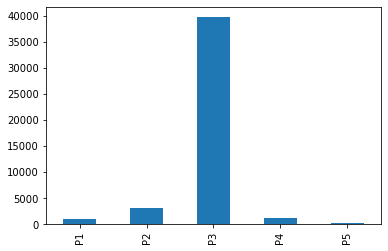

In [6]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [7]:
df['Component'].value_counts()

UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: Component, dtype: int64

In [8]:
# Step 1 - data prep
df = df[['Title', 'Description', 'Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title', 'Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [12]:
# This is a clean function from Chapter 4. Typing it here to use 
import html
import re

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [15]:
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

In [17]:
with pd.option_context('display.max_colwidth', None):
    display(df.sample(2))

,Priority,text
4329,P3,Progress bar gets cleared during project creation IMPORTANT: Start a new empty workspace; Start to create a Java project; Enter JUnit as name; Press Finish; ==> Progress bar goes to right; then gets cleared and user has to wait without; knowing whats going to happen.
5230,P3,Java Model not updated properly Win32 0412 Integration; ; I am not sure how to describe the various problems I am now seeing since I ; have seen a variety of problems. However; they all seem to have a common ; theme. The underlying Java Model for a given class is not being updated ; properly as new methods are added or methods are changed.; ; The two examples that I am consistently running across now are:; 1) Search for a given method; and double click in the Task window to bring up ; the java source. Add a new method to the file. I noticed that the Outline ; view nor the Type Hierarchy were updated with the new method. The subclasses ; which did not implement the abstract method were not flagged with errors.; ; 2) Modified a method signature by adding a new parameter. I received two ; errors in my task where classes were using the API. The first one was changed ; without a problem. However the second one; when I try to use Context Assist; ; the method is showing 2 parameters instead of 3; and the new API added above ; does not appear as an option. After closing the window with the added ; parameter; the Context Assist is showing 3 parameters but the new method is ; not appearing as a valid choice. ; ; Its almost like there are multiple working copies and what I see is the wrong ; one. So when I close the window and re-open the file; everything is ok.


In [19]:
# Step 2 - train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Priority'], test_size=0.2, random_state=42, stratify=df['Priority'])

print('Size of Training_Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training_Data  36040
Size of Test Data  9011


In [20]:
# Step 3 - training the ML model
X_train.head()

31250    Add named sets of exclusion filters to breakpo...
17275    Multiple watch (expressions) views When debugg...
24607    project specific settings ignored If one enabl...
11682    Java application launch shortcut error doesnt ...
27101    Exception signature mismatch with multiply-inh...
Name: text, dtype: object

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")

In [25]:
X_train_tf = tfidf.fit_transform(X_train)

In [26]:
from sklearn.svm import LinearSVC
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, y_train)

LinearSVC(random_state=0, tol=1e-05)

In [27]:
# Step 4 - model evaluation
X_test_tf = tfidf.transform(X_test)

y_pred = model1.predict(X_test_tf)

In [29]:
from sklearn.metrics import accuracy_score
print('Accuracy Score - ', accuracy_score(y_test, y_pred))

Accuracy Score -  0.8759294195982688


In [31]:
# compare with a dummy classifier
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred_baseline = clf.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred_baseline))

Accuracy Score -  0.8769281988680502


In [32]:
from sklearn.metrics import confusion_matrix
y_pred = model1.predict(X_test_tf)
confusion_matrix(y_test, y_pred)

array([[  20,    1,  198,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   51, 7824,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

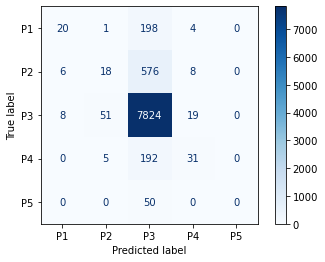

In [36]:
# better to visualize via plot
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(model1,X_test_tf, y_test, values_format='d',cmap=plt.cm.Blues)

In [39]:
# Precision for P3
7824/(198.0+576+7824+192+50)

0.8850678733031674

In [41]:
# Recall for P3
7824/(8.0+51+7824+19+0)

0.9901290812452543

In [42]:
# automated way using classification_report function
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          P1       0.59      0.09      0.16       223
          P2       0.24      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Above results sugget that class imbalance is why the results are like that (e.g. only works for P3)

In [44]:
# Downsampling
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000)

In [45]:
# Create a separate DataFrame containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

In [46]:
# Concatenate the two DataFrames to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

In [47]:
# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: Priority, dtype: int64

In [48]:
# Loading the balanced DataFrame
df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Priority'], test_size=0.2,
                                                   random_state=42, stratify=df['Priority'])
print('Size of Training Data, Test Data', X_train.shape[0], X_test.shape[0])

Size of Training Data, Test Data 7636 1909


In [49]:
# Step 3 - Training the ML model
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, y_train)

LinearSVC(random_state=0, tol=1e-05)

In [51]:
# Step 4 - Model evaluation
X_test_tf = tfidf.transform(X_test)
y_pred = model1.predict(X_test_tf)
print('Accuracy Score -', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score - 0.5081194342587743
              precision    recall  f1-score   support

          P1       0.48      0.32      0.39       223
          P2       0.44      0.47      0.46       608
          P3       0.57      0.66      0.61       800
          P4       0.47      0.36      0.41       228
          P5       0.20      0.02      0.04        50

    accuracy                           0.51      1909
   macro avg       0.43      0.37      0.38      1909
weighted avg       0.50      0.51      0.50      1909



In [52]:
# Not very good for P5 and poor accuracy (~0.5)
# How does the Dummy Classifier look?

clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
y_pred_baseline = clf.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred_baseline))

Accuracy Score -  0.29229963331587216


In [55]:
# Examples where model predictions for these priorities are accurate
frame = { 'text': X_test, 'actual': y_test, 'predicted': y_pred}
result = pd.DataFrame(frame)


with pd.option_context('display.max_colwidth', None):
    display(result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) & 
                   (result['actual'] == result['predicted'])].sample(2))

,text,actual,predicted
23328,False temporary problems reported when using different class name in CU I200412142000; ; open a Messages CU; change getString() to getString1() (just by inserting the character 1); save and build; open another CU that references getString(); try Ctrl-Click in that second CU (does not work); change getString1() back to getString() in the first CU; save and build; try Ctrl-Click in the seconde CU; does not work; which is unexpected,P2,P2
4410,clipboard based copying of java P w2k:; Ctrl-C; Ctrl-V worked at the beginning; after some time they stopped working.; ; linux-motif:; Ctrl-C works; Ctrl-V does not.; ; both:; Ctrl-Insert; Shift-Insert dont work.,P2,P2


In [56]:
# Examples where model predictions for these priorities are NOT accurate
frame = { 'text': X_test, 'actual': y_test, 'predicted': y_pred}
result = pd.DataFrame(frame)


with pd.option_context('display.max_colwidth', None):
    display(result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) & 
                   (result['actual'] != result['predicted'])].sample(2))

,text,actual,predicted
18508,copy fails when using ctrl to select text When I select text in the java editor with ctrl the text is not available for; copy even though it is shown as selected.; ; Specific example: FooBarBaz; ; Go to the start of a line that has the word FooBarBaz at the start of the line.; Press down ctrl and shift. Press arrow right. Foo is selected; but copy is not; enabled in the main menu and ctrl-c will not copy.; ; If I instead just use shift and press arrow right three times Foo is selected; and copy works.; ; I have not been able to reproduce this outside the Java editor. The eclipse; build I have is 200403261517.,P2,P3
1823,Drop to frame does not re-select top stack frame Using the new hot swap support; when I drop to a stack frame; the stack frame ; list updates; but the new top stack frame is not re-selected to display source. ; I believe that firing a (debug) change event on the thread in which the drop ; was performed will update the UI.,P1,P2


## Cross-validation

In [58]:
# Vectorization
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words='english')
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5-folds
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=model1, X=df_tf, y=df['Priority'],cv=5)

print("Validation scores from each iteration of the cross validation ", scores)
print("Mean value across of validation scores ", scores.mean())
print("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.47459403 0.45049764 0.43897328 0.41278156 0.36406496]
Mean value across of validation scores  0.42818229439497124
Standard deviation of validation scores  0.03772713882505244


In [60]:
# Adding in grid search via pipeline
from sklearn.pipeline import Pipeline

training_pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words="english")),
                                   ('model', LinearSVC(random_state=42, tol=1e-5))])

In [61]:
grid_param = [{
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range': [(1,3), (1,6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range': [(1,3), (1,6)],
    'model__C': [1,10],
    'model__tol': [1e-2,1e-3]
}]

In [62]:
from sklearn.model_selection import GridSearchCV
gridSearchProcessor = GridSearchCV(estimator=training_pipeline, param_grid=grid_param, cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=42,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

In [63]:
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}


In [64]:
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Best result identified by grid search  0.45322158198009427


In [70]:
# To see all the results - top 5
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)

with pd.option_context('display.max_colwidth', None):
    display(gridsearch_results[['rank_test_score', 'mean_test_score', 'params']].sort_values(by=['rank_test_score'])[:5])

,rank_test_score,mean_test_score,params
0,1,0.453222,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"
2,2,0.452383,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}"
3,3,0.451964,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 6)}"
1,4,0.450602,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}"
8,5,0.438240,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"


In [72]:
# Now to evaluate this model
best_model = gridSearchProcessor.best_estimator_

y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred))

Accuracy Score -  0.8313253012048193


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          P1       0.88      0.74      0.81       223
          P2       0.84      0.80      0.82       608
          P3       0.80      0.93      0.86       800
          P4       0.90      0.73      0.81       228
          P5       0.96      0.52      0.68        50

    accuracy                           0.83      1909
   macro avg       0.88      0.74      0.79      1909
weighted avg       0.84      0.83      0.83      1909



In [74]:
# Compare with the dummy classifier for this new data
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred_baseline = clf.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test,y_pred_baseline))

Accuracy Score -  0.41906757464641176


In [75]:
print(classification_report(y_test,y_pred_baseline))

              precision    recall  f1-score   support

          P1       0.00      0.00      0.00       223
          P2       0.00      0.00      0.00       608
          P3       0.42      1.00      0.59       800
          P4       0.00      0.00      0.00       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.42      1909
   macro avg       0.08      0.20      0.12      1909
weighted avg       0.18      0.42      0.25      1909



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# Further deep dive into where the best model succeeds
frame = { 'text': X_test, 'actual': y_test, 'predicted': y_pred }
result = pd.DataFrame(frame)

with pd.option_context('display.max_colwidth', None):
    display(result[result['actual'] == result['predicted']].sample(2))

,text,actual,predicted
19624,conditional breakpoint encountered runtime exception conditional breakpoint encountered runtime exception ; reason evaluation faile ; thread not suspended; ; ; this is the condition name.length()==0; name is a String property; that y ; have initialized and empty String; it should have other values but never null.,P3,P3
32123,Clean up parantheses are not recognizing comment // If you have a // comment inside an if statement and do a Source/Clean up... and select Always for Use parentheses around conditions you will get a slight code corruption:; ; See example; Before:; ------------; if (a 1 //; b 2); {; System.out.println(Hello World!);; }; ------------; ; After:; ------------; if ((a 1 //); (b 2)); {; System.out.println(Hello World!);; }; ------------; ; As you can see the parenthesis is located to the right of the comment mark instead of to the left of the comment mark.; ; An annoying bug; but not very bad.,P3,P3


In [85]:
# Now where does the model fall short?
with pd.option_context('display.max_colwidth', None):
    display(result[result['actual'] != result['predicted']].sample(2))

,text,actual,predicted
17886,Class/Interface selection dialog: Class hierarchy tree view Class/Interface selection dialog:; (e.g. New Java Class dialog Interfaces Add and Superclass Browse); ; Currently; you enter the first letters of the class/interface and the list of ; matching classes/interfaces appears.; ; It should also be possible to select the class/interface from the ; package/class/interface hierarchy tree.; ; Sometimes you rather know where to find the class/interface than what its name ; starts with.,P4,P3
16446,Sorting/collating members by interface and super type It would be useful to be able to sort the methods in the Members view by the interfaces and super ; types they are declared in.; Each interface implemented by the type could be a node in the Members tree; with the interfaces ; methods under each node.; ; e.g. Members for Integer; Comparable; compareTo(Object); Number; byteValue(); doubleValue(); ...; decode() ; getInteger(); etc...,P5,P3


## Additional exploration outside the book

In [94]:
# Trying logistic regression
from sklearn.linear_model import LogisticRegression
training_pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words="english")),
                                   ('model', LogisticRegression(random_state=42))])



In [111]:
grid_param = [{
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range': [(1,3), (1,6)],
    'model__penalty': ['l2'],
    'model__C': [0.01, 0.1, 1.0],
    'model__solver':['sag']
}, {
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range': [(1,3), (1,6)],
    'model__C': [0.01, 0.1, 1.0],
    'model__solver': ['sag']
}]

In [112]:
gridSearchProcessor = GridSearchCV(estimator=training_pipeline, param_grid=grid_param, cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'model__C': [0.01, 0.1, 1.0],
                          'model__penalty': ['l2'], 'model__solver': ['sag'],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [0.01, 0.1, 1.0],
                          'model__solver': ['sag'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

In [113]:
logreg = gridSearchProcessor.best_estimator_
logreg

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words='english')),
                ('model', LogisticRegression(random_state=42, solver='sag'))])

In [117]:
logreg_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", logreg_params)

Best alpha parameter identified by grid search  {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'sag', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}


In [119]:
logreg_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", logreg_result) # quite poor

Best result identified by grid search  0.4589837611314825


In [149]:
# Trying boosting
from sklearn.ensemble import GradientBoostingClassifier

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
X_train_tf = tfidf.fit_transform(X_train)

gbst = GradientBoostingClassifier()
gbst.fit(X_train_tf, y_train)

GradientBoostingClassifier()

In [154]:
y_train_gbst = gbst.predict(X_train_tf)
print('Accuracy Score -', accuracy_score(y_train, y_train_gbst))


Accuracy Score - 0.6661864850707176


In [168]:
# Adding more estimators
gbst = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, max_depth=4)
gbst.fit(X_train_tf, y_train)

y_train_gbst = gbst.predict(X_train_tf)
print('Accuracy Score -', accuracy_score(y_train, y_train_gbst))


Accuracy Score - 0.7048192771084337


In [166]:
# Additional experimentation - but didn't work
gbst = GradientBoostingClassifier(learning_rate=0.01,max_depth=4)
gbst.fit(X_train_tf, y_train)

y_train_gbst = gbst.predict(X_train_tf)
print('Accuracy Score -', accuracy_score(y_train, y_train_gbst))


Accuracy Score - 0.5247511786275537


In [169]:
y_pred_gbst = gbst.predict(X_test_tf)
print('Accuracy Score -', accuracy_score(y_test, y_pred_gbst))
print(classification_report(y_test,y_pred_gbst))

Accuracy Score - 0.5060240963855421
              precision    recall  f1-score   support

          P1       0.57      0.17      0.27       223
          P2       0.49      0.34      0.40       608
          P3       0.51      0.82      0.63       800
          P4       0.54      0.29      0.38       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.51      1909
   macro avg       0.42      0.32      0.34      1909
weighted avg       0.50      0.51      0.47      1909



In [173]:
# Try the ensemble model with logistic regression and gradient boosting
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression(penalty='l2', solver='sag',C=1.0)
gbst = GradientBoostingClassifier(learning_rate=0.01,max_depth=4)

model = VotingClassifier(estimators=[('logreg', logreg), ('gbst', gbst)], voting='hard')

In [174]:
model.fit(X_train_tf, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression(solver='sag')),
                             ('gbst',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=4))])

In [176]:
model.score(X_train_tf,y_train)

0.6773179675222629

In [181]:
model.score(X_test_tf,y_test)

0.5138816134101624

In [182]:
# SVM still performed best here